In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchlens as tl # a library to get activations from network
import numpy as np


# Understanding Grokking through Correlation Structure

Adam Shai, 2023.03.05
adamimos@gmail.com

This work follows up on the transformer grokking work, focussing on the example of modular addition in a 1 layer transformer network. 
I want to study the correlation structure between the activations in the network across the different possible inputs. This example is useful
because we can easily enumerate all the different possible inputs and get the network activations completely.

The correlation analysis is inspired by work in neuroscience analysing information processing and sensory representation, especially in the cortex, in large populations of neurons (in neuroscience large means ~100-10,000 neurons). There are a number of interesting things to say about the situation in neuroscience vs. deep learning and the use of studying correlations, but I'll leave that for another time.

Let's see if we can get a handle on grokking through studying correlation structure!

## Why study correlation structure?

When trying to think about the computation a network carries out, it is natural to think of the architecture, and how that architecture relates to an algorithm that carries out a specified computation. After all, it is the architecture that changes over learning. However, there is a sense in which it is the activations in a network that really carry out the computation. From this point of view, learning is the process of changing the network architecture in order to organize the neuron activations in such a way that they carry out the desired computation. Thus, it seems desireable to study the organization of activations in a network.

But what does "organization of activations" actually mean mathematically? We can think of neural activations in response to a particular input as living in an N-dimensional space, where N is the number of neurons in the network, and the activation of each neuron is a dimension. The activations in response to a particular input are a point in this space. This simple setup allows us to use a number of tools from linear algebra and geometry to study the organization of the activations.

For instance, we can ask how many linear dimensions are needed to capture most of the variance in the activations, in response to a particular set of inputs (for instance, the training set, or the validation set, or over all the possible inputs), and see how this changes over time. A result of this type of analysis might find that over training, activations become more and more concentrated in a low dimensional subspace, which might suggest that the network is learning to represent the input in a more efficient way, or that this is only true after generalization has occured, or that this occurs for some set of inputs but not others, etc. Results here might shed light on the nature of memorization and generalization in neural networks. In general, this type of analysis is carried out using principal component analysis (PCA).

We can similarly ask questions about the relationship between the activations to a set of inputs between two different networks, or between two different parts or layers in the same network. This type of analysis tells us about how the structure of activations in one part of a network relates to the structure in some other part. Do two parts of a network "sync up" over training, are there different subnetworks that account for global coordination vs. local computations? This type of analysis is carried out using canonical correlation analysis (CCA).

## Summary of plots (honestly I didn't get as far as I wanted to, so this is a bit of a mess)
I never got to try out CCA :/

In the plots that follow you will find the following:
1. Looking at the attention head responses to every possible input, over training. This is just to get a sense of how the patterns are changing over learning.
2. A plot of the number of frequencies needed to capture 90% of the variance in the attention head responses to every possible input, over training. This is a measure of how many dimensions are needed to capture most of the variance in the attention head responses. In general we see this decrease over training, showing that the responses are becoming more oscillatory.
3. Same plot for the MLP output layer
4. For 5 different modules of the network (e.g. the attention head after the softmax, the embedding layer, the MLP output, etc.) we plot the variance explained by principle component, and see how that changes over training. We generally find that the variance explained by the first principle component increases over training, showing that the activations are becoming more restricted to a low dimensional linear subspace.
5. A similar plot but seen from a different point of view: we ask, how many PCs do we need to capture 95% of the variance in the activations, for the different modules, over epochs. In this way we can look at the dynamics of how many PCs are needed to capture most of the variance in the activations. 
6. I was able to look at how these plots compare over the training vs. validation data, and it turns out they don't. I'm not sure how general this result is, or if its particular to this example. My intutiton would be that in general, activations in response to training data should show lower dimensionality than in response to held out data. But this was not the case. I think this might have something to do with the nature of the generalization in this task and how the data is set up. Probably something to do with the distribution of the training data and how it relates to the total data. I'm not sure.

The main finding is that the activations in the network become lower dimensional as training goes on.

## Recreating the grokking results for modular addition

Below is my code to recreate the results of the grokking work for modular addition. We save the state of the network every 10 epochs during training. We get nice grokking results. We've saved all the data in `training_dict.pt` if you don't want to train from scratch. It took ~15 minutes using my GPU.

### Network, training, and data hyperparameters

In [2]:
 # we are going to do modular addition
# our task is to take inputs a,b \in {0,...,P-1} for some prime P and predict a+b mod P, call the result c
# input is of the form "a b = c"
# hyperparameters
P = 113 # the prime number
d_vocab = P+1 # the size of the vocabulary, add one for = sign
d_model = 128 # the width of the residual streal (embedding dimension)
d_head = 32 # the width of each head, 4 of them
d_mlp = 512 # the width of the feed forward layer
input_size = 3 # the length of the context, a, b, and =

# training params
training_percent = 0.4
learning_rate = 0.001
lam = 1.
epochs = 40000

# generate all possible a,b,c triples, there should be 113*113 of them
# we will use these to train the model
# keep these all in a torch tensor of size (113*113, 4)
torch.manual_seed(0)
triples = torch.zeros((P*P, 4), dtype=torch.long)
for i in range(P):
    for j in range(P):
        triples[i*P+j, 0] = i
        triples[i*P+j, 1] = j
        triples[i*P+j, 2] = P
        triples[i*P+j, 3] = (i+j)%P

# use 30% of the data for training, 70% for validation
# randomly choose the 30 percent
train_size = int(training_percent*len(triples))
data_size = len(triples)
inds = torch.randperm(data_size)
train_indices = inds[:train_size]
val_indices = inds[train_size:]
train_data = triples[train_indices]
val_data = triples[val_indices]

# make sure theres no overlap between train and val
assert len(set(train_indices).intersection(set(val_indices))) == 0

print("the number of training examples is", len(train_data))
print("the number of validation examples is", len(val_data))
print("total number of examples is", len(train_data)+len(val_data))
print("here are some examples of training data")
print(train_data[:10])


the number of training examples is 5107
the number of validation examples is 7662
total number of examples is 12769
here are some examples of training data
tensor([[ 37,   1, 113,  38],
        [ 23,   9, 113,  32],
        [  2,  43, 113,  45],
        [  7,  34, 113,  41],
        [ 42, 101, 113,  30],
        [ 81,  71, 113,  39],
        [ 55,  12, 113,  67],
        [  1,   3, 113,   4],
        [ 46,  78, 113,  11],
        [ 18,  18, 113,  36]])


### The Simple Transformer

This should be pretty straightforward. Hopefully I didn't mess anything up! At least it seems to learn.

In [3]:
class Head(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.W_Q = nn.Linear(d_model, d_head, bias=False)
        self.W_K = nn.Linear(d_model, d_head, bias=False)
        self.W_V = nn.Linear(d_model, d_head, bias=False)
        self.W_O = nn.Linear(d_head, d_head, bias=False)
        self.register_buffer("mask", torch.tril(torch.ones(input_size, input_size)))

    def forward(self, x):
        # x is of size (batch_size, input_size, d_model)
        # get the query, key, and value
        Q = self.W_Q(x) # (batch_size, input_size, d_head)
        K = self.W_K(x) # (batch_size, input_size, d_head)
        V = self.W_V(x) # (batch_size, input_size, d_head)
        # get the attention weights
        A = torch.einsum("bid,bjd->bij", Q, K) / (d_head**0.5) 
        A = A.masked_fill(self.mask==0, float("-inf"))
        A = F.softmax(A, dim=-1) # the rows of A sum to 1
        # apply the attention weights
        O = torch.einsum("bij,bjd->bid", A, V) # this is the output of the attention head, we weight the values by the attention weights
        O = self.W_O(O) # (batch_size, input_size, d_model)
        return O 
    
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp):
        super().__init__()
        self.W_in = nn.Linear(d_model, d_mlp)
        self.W_out = nn.Linear(d_mlp, d_model)
        
    def forward(self, x):
        # x is of size (batch_size, input_size, d_model)
        x = self.W_in(x) # (batch_size, input_size, d_mlp)
        x = F.relu(x)
        x = self.W_out(x) # (batch_size, input_size, d_model)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(d_vocab, d_model)
        self.pos_embedding = nn.Embedding(input_size, d_model)
        self.heads = nn.ModuleList([Head(d_head) for _ in range(4)])
        self.mlp = MLP(d_model, d_mlp)
        self.unembedding = nn.Linear(d_model, d_vocab)

    def forward(self, x):
        # x is of size (batch_size, input_size)
        # embed the input
        x = self.embedding(x) + self.pos_embedding(torch.arange(input_size, device=x.device))
        # apply the attention heads, stack them
        x = x + torch.cat([head(x) for head in self.heads], dim=-1) # (batch_size, input_size, d_model)
        # apply the MLP
        x = x + self.mlp(x)
        # unembed the output
        x = self.unembedding(x)
        return x

### Training
Change the `TRAIN` variable to True if you want to rerun training

In [4]:
TRAIN = False
import copy

# make a training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

# train on all the training data
x = train_data[:, :input_size].to(device)
y = train_data[:, -input_size:].to(device) # (batch_size, input_size)

x_val = val_data[:, :input_size].to(device)
y_val = val_data[:, -input_size:].to(device) # (batch_size, input_size)

# make a function that evaluates the loss on both the training and validation data
@torch.no_grad()
def evaluate_loss(model):
    model.eval()
    # training data
    logits = model(x) # (batch_size, input_size, d_vocab)
    logits, y_last = logits[:, -1], y[:, -1] # (batch_size, d_vocab), (batch_size,)
    train_loss = F.cross_entropy(logits, y_last, reduction="mean")
    train_acc = (torch.argmax(logits, dim=-1) == y_last).float().mean()
    # validation data
    logits = model(x_val) # (batch_size, input_size, d_vocab)
    logits, y_val_last = logits[:, -1], y_val[:, -1] # (batch_size, d_vocab), (batch_size,)
    val_loss = F.cross_entropy(logits, y_val_last, reduction="mean")
    val_acc = (torch.argmax(logits, dim=-1) == y_val_last).float().mean()
    model.train() # put the model back in training mode
    return train_loss, train_acc, val_loss, val_acc

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=lam)#, betas = (0.9, 0.98))

if TRAIN:
    # a dictionary to store the training and validation losses
    training_dict = {}
    training_dict["train_data"] = train_data
    training_dict["val_data"] = val_data
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        # get the predictions
        preds = model(x) # (batch_size, input_size, d_vocab)
        # we only care about the last prediction
        preds = preds[:, -1] # (batch_size, d_vocab)
        y_last = y[:, -1] # (batch_size,)
        loss = F.cross_entropy(preds, y_last, reduction="mean")
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # print the loss and epoch
        if epoch%10==0:
            train_loss, train_acc, val_loss, val_acc = evaluate_loss(model)
            # print the loss and accuracy, with two decimal places, add to the pbar
            pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.8f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            # keep track of these values in a dictionary
            # add learning rat to end of pbar
            pbar.set_postfix({"lr": optimizer.param_groups[0]["lr"]})
            training_dict[epoch] = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
            # add the model parameters to the training dict, deepcopy to avoid memory issues
            training_dict[epoch]["model"] = copy.deepcopy(model.state_dict())


    # save the training dict
    torch.save(training_dict, "training_dict.pt")

        


In [5]:
# get the embedding matrix
embedding_matrix = model.embedding.weight.detach().cpu().numpy()

# get the output of the mlp
mlp_output = model.mlp.W_out.weight.detach().cpu().numpy()

# get the output of the unembedding layer
unembedding_matrix = model.unembedding.weight.detach().cpu().numpy()

# print the shape of each of these
print(embedding_matrix.shape)
print(mlp_output.shape)
print(unembedding_matrix.shape)

(114, 128)
(128, 512)
(114, 128)


In [6]:
model

Model(
  (embedding): Embedding(114, 128)
  (pos_embedding): Embedding(3, 128)
  (heads): ModuleList(
    (0-3): 4 x Head(
      (W_Q): Linear(in_features=128, out_features=32, bias=False)
      (W_K): Linear(in_features=128, out_features=32, bias=False)
      (W_V): Linear(in_features=128, out_features=32, bias=False)
      (W_O): Linear(in_features=32, out_features=32, bias=False)
    )
  )
  (mlp): MLP(
    (W_in): Linear(in_features=128, out_features=512, bias=True)
    (W_out): Linear(in_features=512, out_features=128, bias=True)
  )
  (unembedding): Linear(in_features=128, out_features=114, bias=True)
)

### Load the training results

In [7]:
# clear cuda memory
torch.cuda.empty_cache()

# load training dict .pt file
training_dict = torch.load("training_dict.pt")
# move everything in the training dictionary to the cpu
# the structure of the training dict is:
# training_dict[epoch] = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
# training_dict[epoch]["model"] = model.state_dict()
for epoch in training_dict:
    if type(epoch) == int:
        for key in training_dict[epoch]:
            if type(training_dict[epoch][key]) == torch.Tensor:
                training_dict[epoch][key] = training_dict[epoch][key].cpu()

# get the training and validation data
train_data = training_dict["train_data"] # (batch_size, input_size)
val_data = training_dict["val_data"] # (batch_size, input_size)


### We see Grokking!

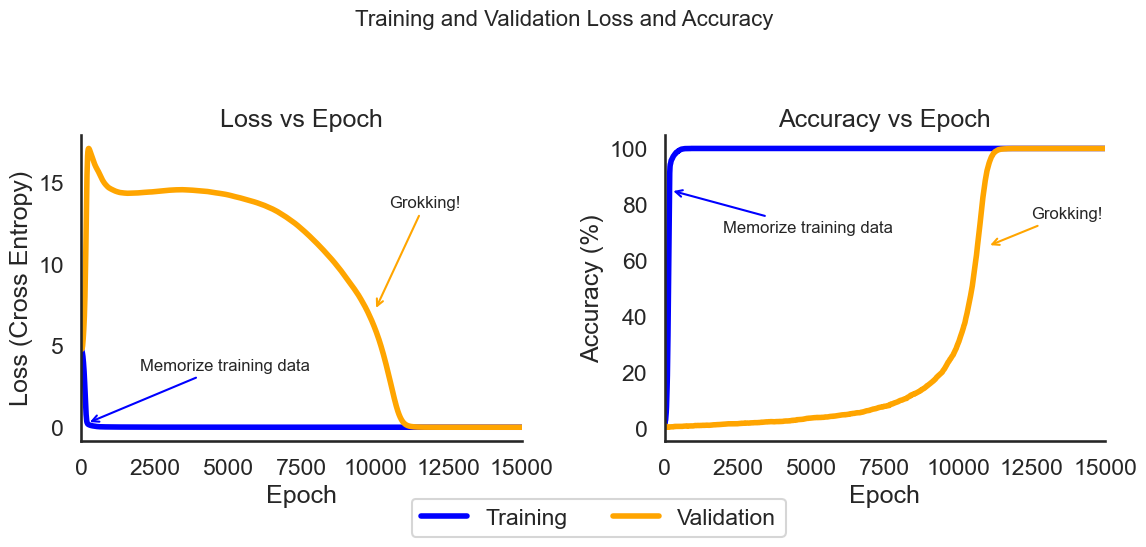

Memorization
------------------
Memorize loss epoch: 120
Memorize acc epoch: 130


Grokking
------------------
Grok acc epoch: 10700
Grok loss epoch: 10540


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

train_loss = [training_dict[epoch]["train_loss"] for epoch in training_dict if type(epoch) == int]
val_loss = [training_dict[epoch]["val_loss"] for epoch in training_dict if type(epoch) == int]
train_acc = [100*training_dict[epoch]["train_acc"] for epoch in training_dict if type(epoch) == int]
val_acc = [100*training_dict[epoch]["val_acc"] for epoch in training_dict if type(epoch) == int]
# lambda function for the above

epochs = [epoch for epoch in training_dict if type(epoch) == int]
sns.set_style("white")
sns.set_context("talk")

# plot the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.suptitle("Training and Validation Loss and Accuracy", fontsize=16, y=1.05)

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training", linewidth=4, color='blue')
plt.plot(epochs, val_loss, label="Validation", linewidth=4, color='orange')
plt.xlim([0, 15000])
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)")
plt.title("Loss vs Epoch")

# Add an arrow for memorize training data
plt.annotate("Memorize training data", xy=(200, 0.25), xytext=(2000, 3.5), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="blue", arrowstyle="->"))

plt.annotate("Grokking!", xy=(10000, 7.15), xytext=(10500, 13.5), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="orange", arrowstyle="->"))

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training", linewidth=4, color='blue')
plt.plot(epochs, val_acc, label="Validation", linewidth=4, color='orange')
plt.xlim([0, 15000])

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
sns.despine()

# Add an arrow for grokking
plt.annotate("Memorize training data", xy=(200, 85), xytext=(2000, 70), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="blue", arrowstyle="->"))

plt.annotate("Grokking!", xy=(11000, 65), xytext=(12500, 75), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="orange", arrowstyle="->"))

plt.tight_layout()
# Place the legend at the center underneath both plots with two columns
plt.legend(["Training", "Validation"], bbox_to_anchor=(-0.15, -0.15), loc="upper center", ncol=2)
# make vertical line at mem_acc_epoch and grok_acc_epoch

plt.show()

# function to find absolute value of max difference
abs_argmax = lambda x: np.argmax(np.abs(np.diff(x)))

mem_loss_epoch = epochs[abs_argmax(train_loss[0:1500])]
grok_loss_epoch = epochs[abs_argmax(val_loss[500:1500])+500]

mem_acc_epoch = epochs[abs_argmax(train_acc[0:1500])]
grok_acc_epoch = epochs[abs_argmax(val_acc[0:1500])]



print(f"Memorization")
print(f"------------------")
print(f"Memorize loss epoch: {mem_loss_epoch}")
print(f"Memorize acc epoch: {mem_acc_epoch}")
print(f"\n")
print(f"Grokking")
print(f"------------------")
print(f"Grok acc epoch: {grok_acc_epoch}")
print(f"Grok loss epoch: {grok_loss_epoch}")

Incredibly, the network memorizes the training data after only a hundren epochs or so, and yet it takes more than 10000 more epochs for the test set accuracy to budge much beyond 0. **What is happening in the network over this time?**

# Diagram of the model archetecture, with the names of the different parts of the transformer
In order to use torchlens to get activations from the network we need to know the names of the different modules in the network. Here is a diagram of the network with the names of the different modules.

c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\torchlens\torch_decorate.py:193: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  attr = getattr(input_tensor, attr_name)


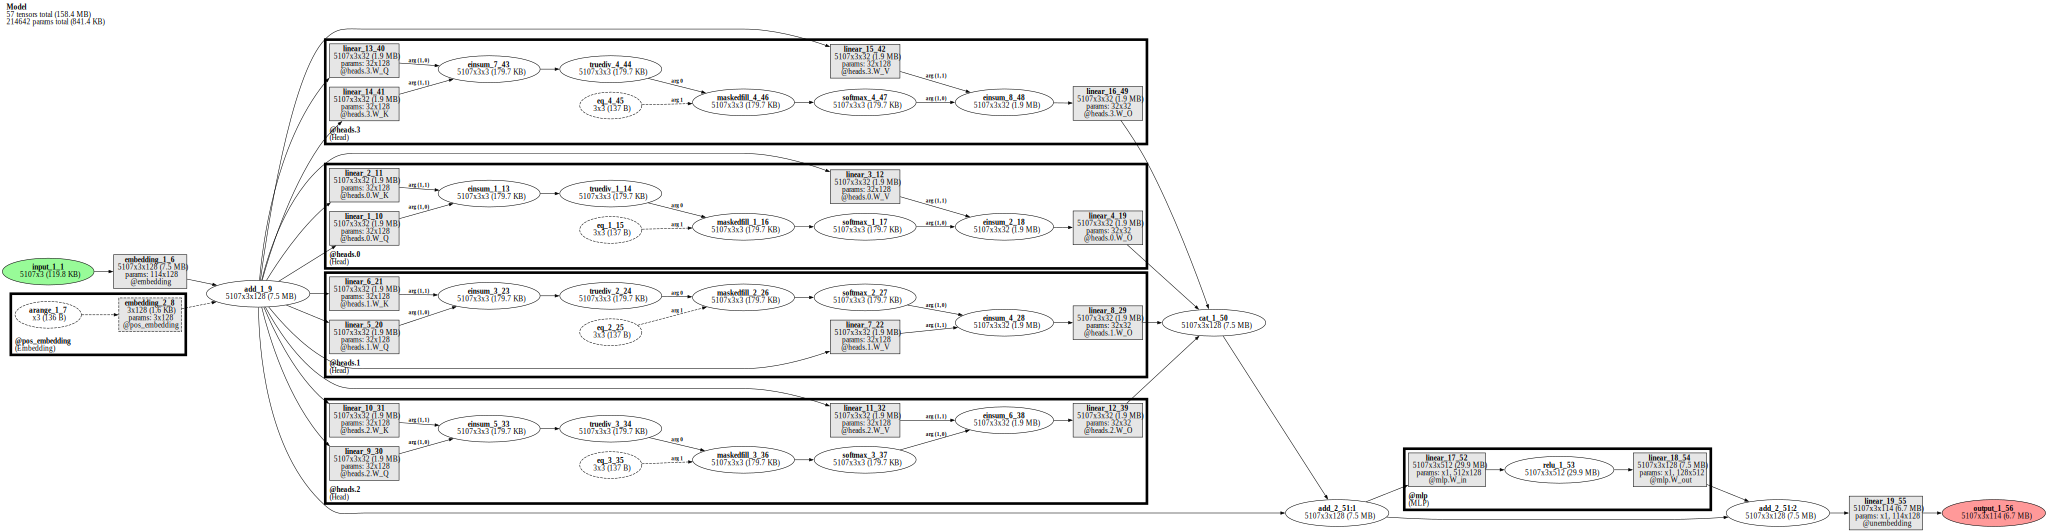

In [12]:
# get the layers for the model
model = Model().to(device)
tl.show_model_graph(model, x, vis_direction="horizontal")

# Get activations over learning

In [49]:
GET_ACTIVATIONS = False

import os
import gc
"""
Load a trained neural network model from a training dictionary and extract the activations of all its layers on a given dataset. The resulting activations are stored in a dictionary with keys representing epochs.

Args:
    training_dict (dict): a dictionary containing information about the trained model, including the model's state_dict at various epochs
    x (torch.Tensor): the input dataset to extract activations from
    x_val (torch.Tensor): the validation dataset to extract activations from
    device (str): the device to use for computation, either 'cpu' or 'cuda'

Returns:
    dict: a dictionary of activations for each epoch, with keys representing epochs and values containing the activations of each layer of the neural network model for the given dataset.

Note that the code uses a `torchlens` library to extract the activations of all layers of the neural network model.    
"""


# print all the avaialble epochs in the training dict, we are only interested in epochs up to a value of 15000
epochs = [epoch for epoch in training_dict if type(epoch) == int and epoch <= 20000]
# only keep epochs that are divisible by 1000
epochs = [epoch for epoch in epochs if epoch%50==0]

# loop through each of the epochs and get the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pbar = tqdm(epochs)
W_E = {} # dictionary to store activations
device = "cpu"

train_len = len(train_data)
val_len = len(val_data)
all_data = torch.cat([train_data, val_data], dim=0)

# Add a fifth column that is 0 for train data and 1 for val data
col5 = torch.cat([torch.zeros(train_len), torch.ones(val_len)], dim=0)
all_data = torch.cat([all_data, col5.unsqueeze(1)], dim=1)

# Sort the data first by the second column, then by the first column
sorted_indices = np.lexsort((all_data[:, 1].numpy(), all_data[:, 0].numpy()))
all_data = all_data[sorted_indices]

train_inds = torch.where(all_data[:, 4] == 0)[0]
val_inds = torch.where(all_data[:, 4] == 1)[0]

# first 3 columns
x = all_data[:, 0:3].int()
model_parts = {'attn_softmax': ['softmax_4_47', 'softmax_1_17', 'softmax_2_27', 'softmax_3_37'],
              'mlp_relu': 'relu_1_53',
              'embed': 'add_1_9',
              'attn_out': 'cat_1_50',
              'mlp_out': 'linear_18_54'}

# H:/activations_addition
ACT_FOLDER = os.path.join("H:/", "activations_addition")
if not os.path.exists(ACT_FOLDER):
    os.mkdir(ACT_FOLDER)

if GET_ACTIVATIONS:
    for epoch in pbar:
        model = Model().to(device)
        model.load_state_dict(training_dict[epoch]["model"])
        model.eval()
        with torch.no_grad():
            acts = tl.get_model_activations(model, x, which_layers='all')
        # go through all layers
        for part in acts.layer_labels:
            activations = acts[part].tensor_contents.numpy()
            # save the activations as part_epepoch.npy
            np.save(f"{ACT_FOLDER}/{part}_{epoch}.npy", activations)
        del model
        del acts
        gc.collect()

  0%|          | 0/401 [00:00<?, ?it/s]

In [50]:
from typing import Union, List

trial_types = ['all', 'train', 'val']
model_parts = {'attn_softmax': ['softmax_4_47', 'softmax_1_17', 'softmax_2_27', 'softmax_3_37'],
              'mlp_relu': 'relu_1_53',
              'embed': 'add_1_9',
              'attn_out': 'cat_1_50',
              'mlp_out': 'linear_18_54'}

def get_activations(part, epoch, act_folder=ACT_FOLDER):
    # if part is a string then we put it in a list
    if type(part) == str:
        part = [part]
    
    all_activations = []
    for p in part:
        # load the activations
        activations = np.load(f"{act_folder}/{p}_{epoch}.npy")
        # if this is the first part then initialize the array
        all_activations.append(activations)

    return np.squeeze(np.array(all_activations))



In [51]:
# try loading some activations
epoch = 20000
part = 'attn_softmax'
attn_softmax_acts = get_activations(model_parts[part], epoch)
print(attn_softmax_acts.shape)
mean_attn_softmax_acts = np.mean(attn_softmax_acts, axis=1)


(4, 12769, 3, 3)


## Mean activation pattern per head

this is mostly just to recreate something from the original grokking work, to make sure we can do basic things.

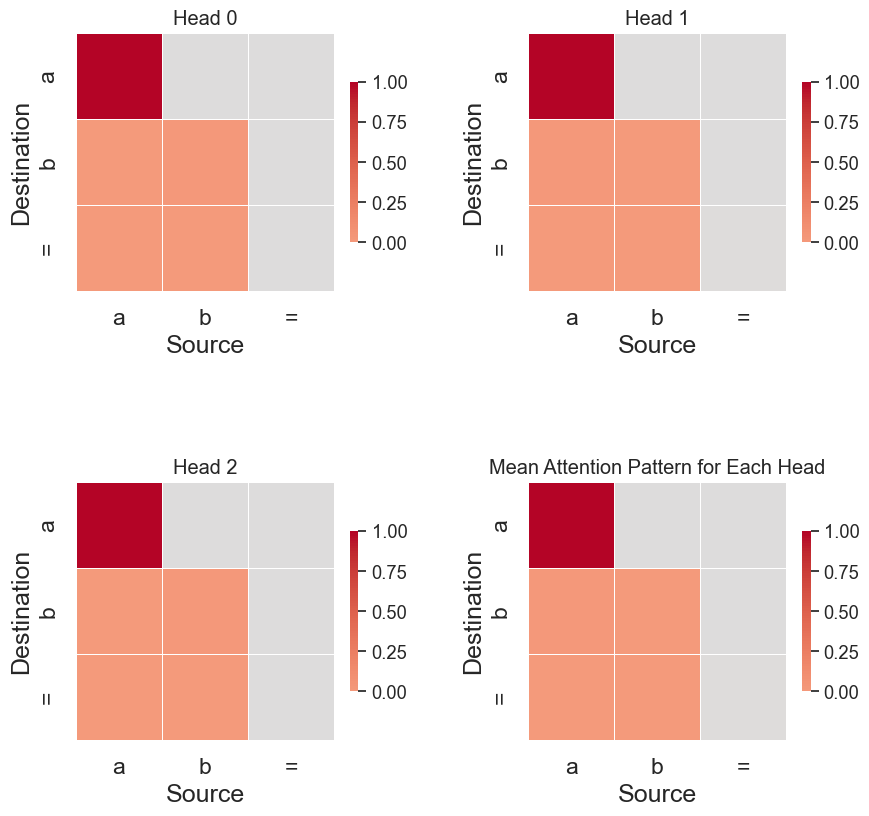

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm, ListedColormap

# Your data loading and processing code

# Plot the mean attention pattern for each head
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

# Set plot aesthetics
sns.set(style="white", context="notebook", font_scale=1.2)

# Create a custom color map
cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=256))

labels = ["a", "b", "="]

for head in range(4):
    ax = axes[head]
    sns.heatmap(mean_attn_softmax_acts[head], cmap=cmap, square=True, linewidths=.5, vmin=-1, vmax=1, cbar_kws={"shrink": .5}, ax=ax, norm=TwoSlopeNorm(0))

    ax.set_title(f"Head {head}")
    
    tick_locs = [x + 0.5 for x in range(len(labels))]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Source")
    ax.set_yticks(tick_locs)
    ax.set_yticklabels(labels)
    ax.set_ylabel("Destination")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title("Mean Attention Pattern for Each Head")
plt.show()


# Attention Patterns Over Training

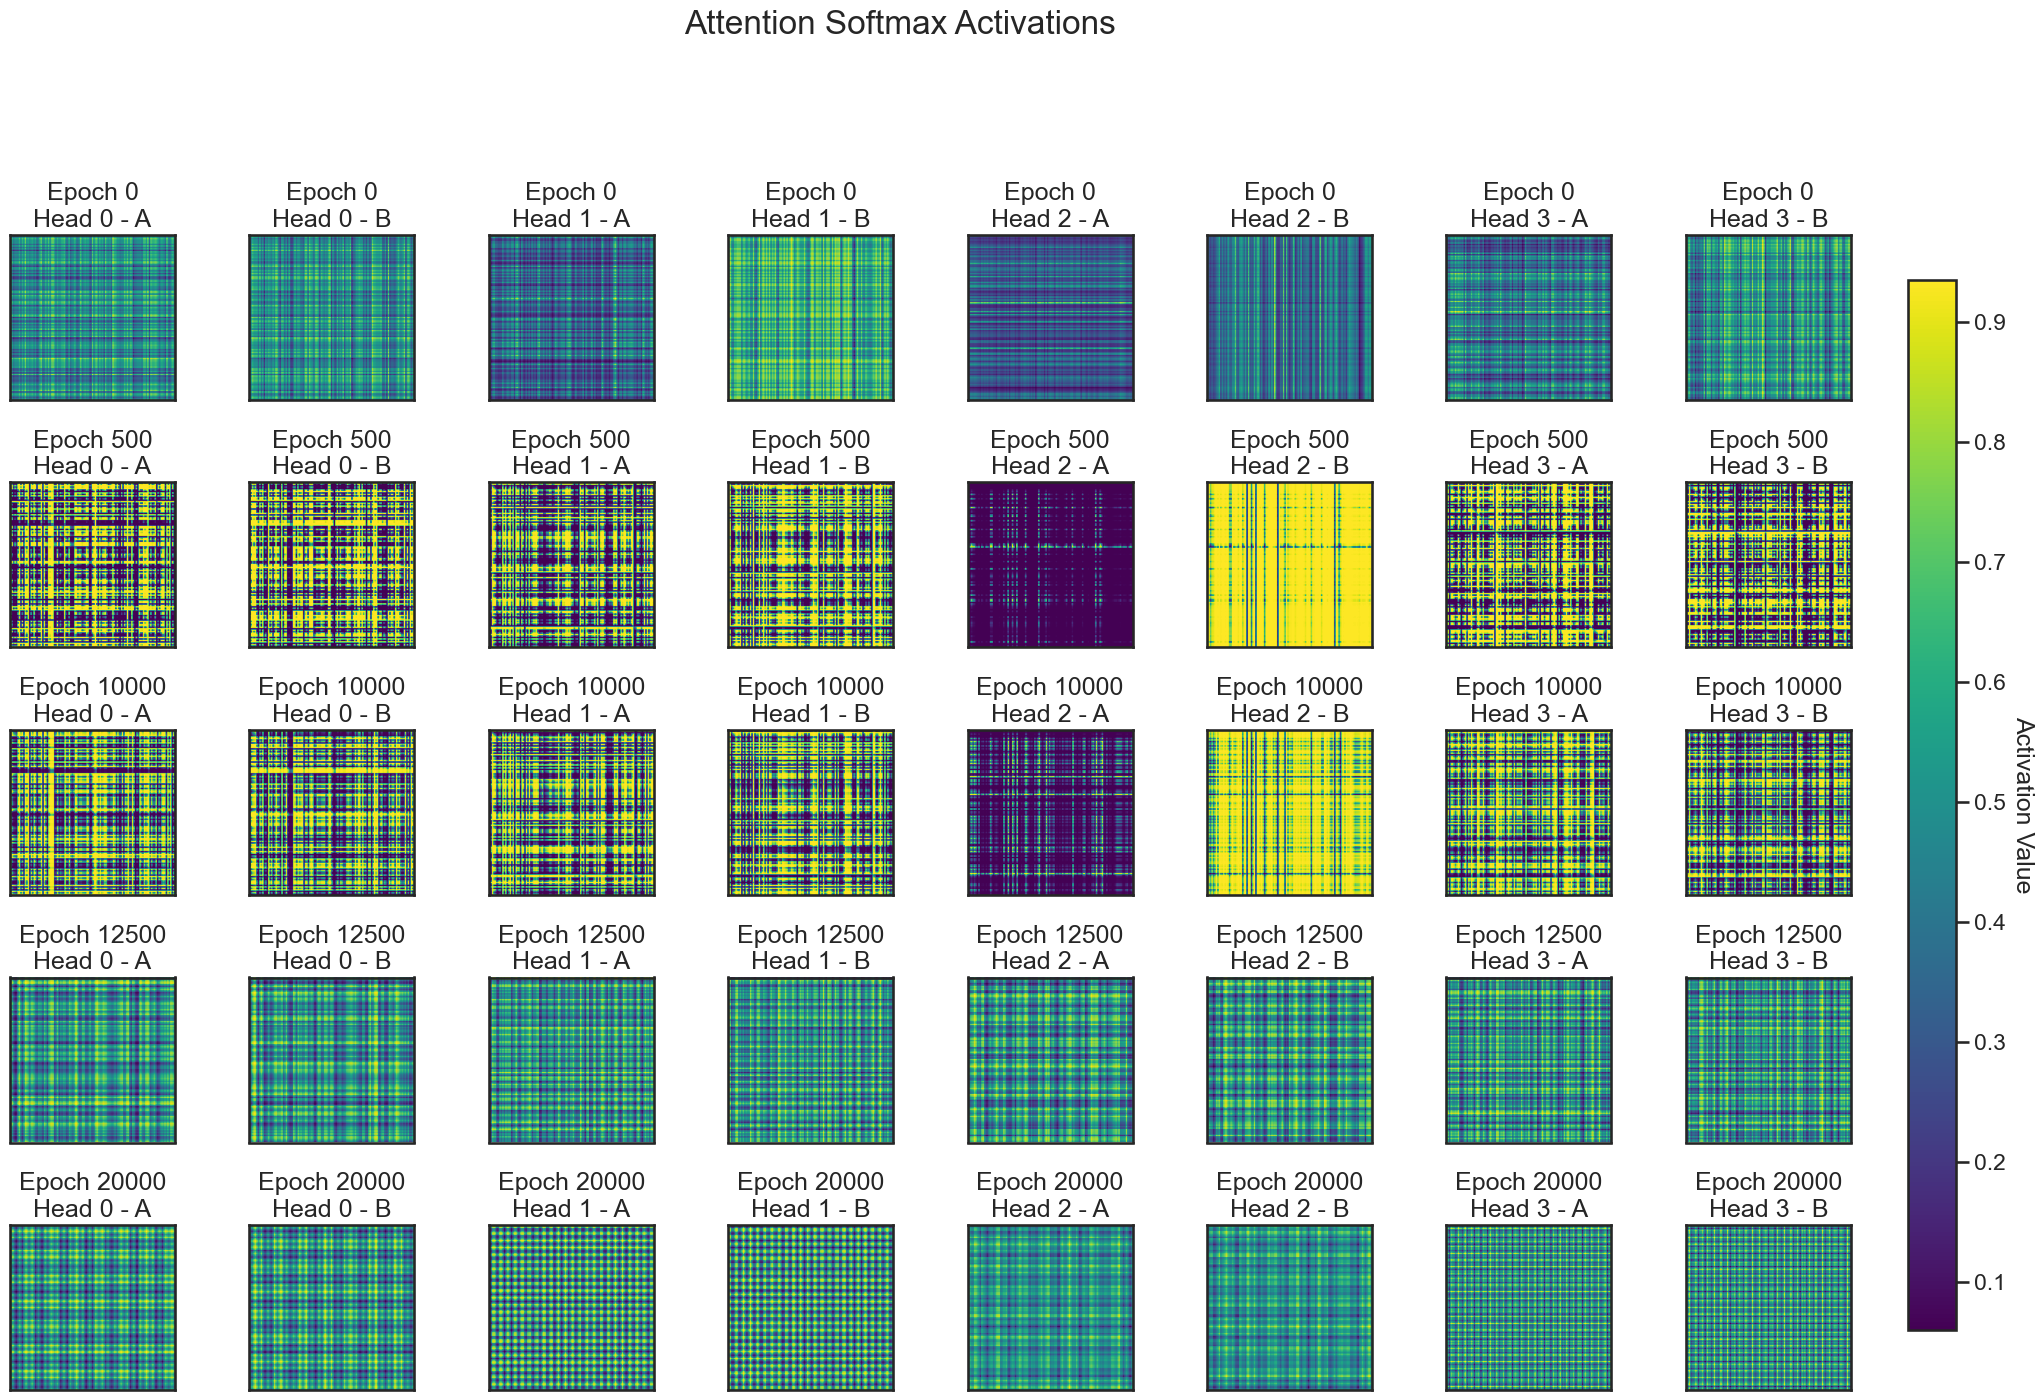

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Set the Seaborn style and font scale
sns.set_style("white")
sns.set_context("talk")

# Prepare the figure and subplots
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(24, 15))
fig.suptitle('Attention Softmax Activations', fontsize=24, y=1.03)

# List of epochs and their labels
epochs = [0, 500, 10000, 12500, 20000]
epoch_labels = ["Epoch 0", "Epoch 500", "Epoch 10000", "Epoch 12500", "Epoch 20000"]

for row, epoch, epoch_label in zip(axes, epochs, epoch_labels):
    attn_softmax_acts = get_activations(model_parts[part], epoch)

    for head in range(4):
        for idx, label in enumerate(["A", "B"]):
            ax = row[head * 2 + idx]
            im = ax.imshow(attn_softmax_acts[head, :, -1, idx].reshape(113, 113), cmap='viridis')
            ax.set_title(f"{epoch_label}\nHead {head} - {label}")

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Activation Value', rotation=-90, va="bottom", fontsize=18)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3, right=0.9)

plt.show()


It is pretty clear that as training progresses, the mean activation pattern per head becomes more and more regular, in terms of it's oscillatory structure, and as described in the original work. Let's next quantify this.

## Frequency components per head, over training

C:\Users\adamimos\AppData\Local\Temp\ipykernel_24348\1785584328.py:56: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(data=data, x="Epoch", y="Num Freqs", hue="Head", style="Destination", markers=False, dashes=True, palette=palette, lw=2)


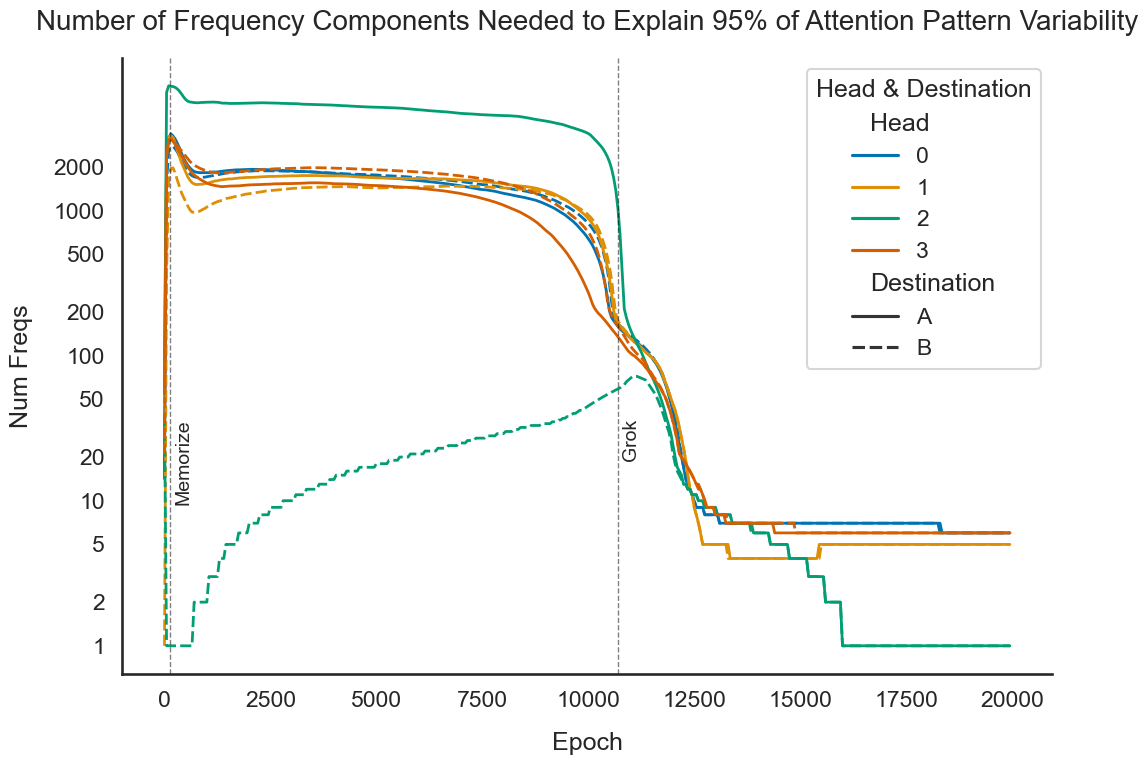

In [25]:
import pandas as pd

def compute_num_freqs(attn_pattern, desired_percentage=.95):
    # attn_pattern should be 113,113
    fft = np.fft.fft2(attn_pattern)
    magnitude = np.abs(fft)
    total_energy = np.sum(magnitude**2)
    normalized_magnitude = magnitude**2 / total_energy
    sorted_indices = np.unravel_index(np.argsort(normalized_magnitude.ravel())[::-1], normalized_magnitude.shape)
    sorted_magnitude = normalized_magnitude[sorted_indices]
    cumulative_energy = np.cumsum(sorted_magnitude)
    # Find the number of frequencies that captures the desired percentage of the energy
    # if desired_percentage is 0.95, then we want the number of frequencies that captures 95% of the energy
    # if this doesn't work, then we return the number of frequencies that captures 100% of the energy
    try:
        num_freqs = np.where(cumulative_energy >= desired_percentage)[0][0] + 1
    except:
        num_freqs = len(cumulative_energy)
    return num_freqs

# Create a list to store the results for each head and A/B
data = []

# Loop over the heads
for head in range(4):
    # Loop over the final dimension (0 for A, 1 for B)
    for idx, label in enumerate(["A", "B"]):
        num_freqs = []
        epochs = np.arange(0, 20000, 50)
        for epoch in epochs:
            attn_softmax_acts = get_activations(model_parts['attn_softmax'], epoch)
            attn_softmax_acts = attn_softmax_acts[head, :, -1, idx].reshape(113, 113)
            num_freqs.append(compute_num_freqs(attn_softmax_acts))

        # Store the results in the data list
        for epoch, num_freq in zip(epochs, num_freqs):
            data.append({"Epoch": epoch, "Num Freqs": num_freq, "Head": head, "Destination": label})
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Your compute_num_freqs function and data preparation code

# Convert the data list to a DataFrame
data = pd.DataFrame(data)

# Set Seaborn style and font scale
sns.set_style("white")
sns.set_context("talk")

# Use colorblind-friendly color palette
palette = sns.color_palette("colorblind")

# Plot the results using Seaborn
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=data, x="Epoch", y="Num Freqs", hue="Head", style="Destination", markers=False, dashes=True, palette=palette, lw=2)
plt.title("Number of Frequency Components Needed to Explain 95% of Attention Pattern Variability", fontsize=20, pad=20)

# Set the y-axis scale to logarithmic
plt.gca().set_yscale("log")

# Optionally, you can set custom y-axis ticks to make the plot more readable
yticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
plt.gca().set_yticks(yticks)
plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Set axis labels
plt.xlabel("Epoch", fontsize=18, labelpad=15)
plt.ylabel("Num Freqs", fontsize=18, labelpad=15)

# Set legend title
ax.legend_.set_title("Head & Destination")

# Remove the top and right spines for a cleaner look
sns.despine()

# add a vertical line at the grokking epoch
plt.axvline(x=mem_acc_epoch, color='black', linestyle='--', alpha=0.5, lw=1)
plt.axvline(x=grok_acc_epoch, color='black', linestyle='--', alpha=0.5, lw=1)

# add label to the vertical line
plt.text(mem_acc_epoch+100, 10, 'Memorize', rotation=90, fontsize=14)
plt.text(grok_acc_epoch+100, 20, 'Grok', rotation=90, fontsize=14)
plt.show()


Some things to note here:
* Sharp increase in number of frequencies needed to explain variance in the activations over the first 100 epochs or so, then it levels off. This is consistent with the network memorizing the training data, and then learning to generalize.
* It seems that there is a single attention pattern (out of 8) that changes slowly(ish) over the stable period between memorization and grokking. One needs to be careful though, since the y-axis is log. It coud be that the other patterns are changing just as much but its hidden by the log scale. In any case, maybe something special is going on there.


## Same thing for MLP layer
We have 512 relu units in the MLP layer. Let's see how many frequencies we need to explain the variance in the activations over training.

In [27]:
import seaborn as sns

# Create a DataFrame to store the results
data = []

# Loop through epochs and neurons to compute the number of frequency components
for epoch in tqdm(range(0, 20000, 50)):
    mlp_relu_acts = get_activations(model_parts['mlp_relu'], epoch)
    for nrn in range(512):
        response_pattern = mlp_relu_acts[:, -1, nrn].reshape(113, 113)
        num_freqs = compute_num_freqs(response_pattern)
        data.append({"Epoch": epoch, "Num Freqs": num_freqs, "Neuron": nrn})

# Convert the data list to a DataFrame
data = pd.DataFrame(data)

  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\adamimos\AppData\Local\Temp\ipykernel_24348\1785584328.py:8: RuntimeWarning: invalid value encountered in divide
  normalized_magnitude = magnitude**2 / total_energy


<Figure size 1200x800 with 0 Axes>

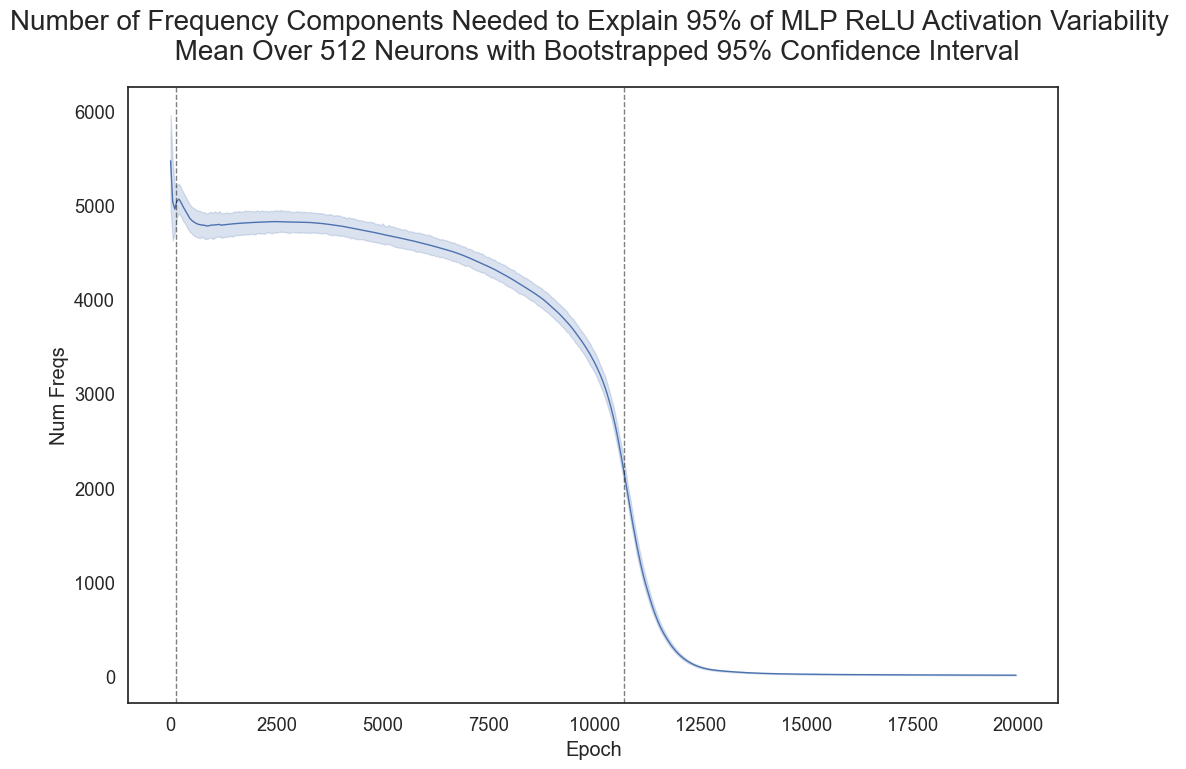

In [29]:
# Set seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

# Create the line plot with seaborn
plt.figure(figsize=(12, 8))
plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x="Epoch", y="Num Freqs", legend=True, linewidth=1)

# add vertical line at the grokking epoch
plt.axvline(x=grok_acc_epoch, color='black', linestyle='--', alpha=0.5, lw=1)
plt.axvline(x=mem_acc_epoch, color='black', linestyle='--', alpha=0.5, lw=1)

# Set plot title and labels
plt.title("Number of Frequency Components Needed to Explain 95% of MLP ReLU Activation Variability \n Mean Over 512 Neurons with Bootstrapped 95% Confidence Interval", fontsize=20, pad=20)
plt.xlabel("Epoch")
plt.ylabel("Num Freqs")

plt.show()


# Compute covariance matrix (do PCA)

## get all the activations over training over all possible inputs

In [98]:
from sklearn.decomposition import PCA

trial_types = ['all', 'train', 'val']
model_parts = {'attn_softmax': ['softmax_4_47', 'softmax_1_17', 'softmax_2_27', 'softmax_3_37'],
              'mlp_relu': 'relu_1_53',
              'embed': 'add_1_9',
              'attn_out': 'cat_1_50',
              'mlp_out': 'linear_18_54'}
trail_type_inds = {'train': train_inds, 'val': val_inds, 'all': np.sort(np.union1d(train_inds, val_inds))}

def get_activations(part, epoch, act_folder=ACT_FOLDER):
    # if part is a string then we put it in a list
    if type(part) == str:
        part = [part]
    
    all_activations = []
    for p in part:
        # load the activations
        activations = np.load(f"{act_folder}/{p}_{epoch}.npy")
        # if this is the first part then initialize the array
        all_activations.append(activations)

    return np.squeeze(np.array(all_activations))

def get_epoch_numbers(act_folder=ACT_FOLDER):
    filenames = os.listdir(act_folder)
    epoch_numbers = sorted(list(set(int(fname.split('_')[-1].split('.')[0]) for fname in filenames if fname.endswith(".npy"))))
    print(f"Found {len(epoch_numbers)} epochs in {act_folder}")
    return epoch_numbers


# now we want to go through each of the model parts and get the acts
exp_var_ratio = {}
epochs = get_epoch_numbers()
for part in model_parts.keys():
    epoch_var_ratio = {}
    for epoch in tqdm(epochs):
        # get the activations
        if part == 'attn_softmax':
            # loop through the heads
            acts = []
            for head in model_parts[part]:
                acts.append(get_activations(head, epoch)[:, :, :]) # trials x neurons)

            acts = np.concatenate(acts, axis=-1)
            if epoch == 0:
                print( f"Got activations for {part}, shape is {acts.shape}")
        else:
            acts = get_activations(model_parts[part], epoch)[:,:,:] # trials x neuron
            if epoch == 0:
                print(f"Got activations for {model_parts[part]}, shape is {acts.shape}") 
            # check if there are any nans in the data

        # the last two dimensions of acts are neurons, so make it so that the last dimension is neurons
        # in other words if acts is (trials, n_a = 2, n_b =8) then we want to reshape it to (trials, n_a*n_b)
        acts = acts.reshape(acts.shape[0], -1) # trials x neurons
            

        # now we want to compute the pca
        pca = PCA(whiten=True)
        pca.fit(acts)

        # now we want to compute the explained variance per component
        # keep track of the exp_var_ratio in a dict
        exp_var = pca.explained_variance_ratio_ # neurons
        epoch_var_ratio[epoch] = exp_var
    exp_var_ratio[part] = epoch_var_ratio

Found 401 epochs in H:/activations_addition


  0%|          | 0/401 [00:00<?, ?it/s]

Got activations for attn_softmax, shape is (12769, 3, 12)


  0%|          | 0/401 [00:00<?, ?it/s]

Got activations for relu_1_53, shape is (12769, 3, 512)


  0%|          | 0/401 [00:00<?, ?it/s]

Got activations for add_1_9, shape is (12769, 3, 128)


  0%|          | 0/401 [00:00<?, ?it/s]

Got activations for cat_1_50, shape is (12769, 3, 128)


  0%|          | 0/401 [00:00<?, ?it/s]

Got activations for linear_18_54, shape is (12769, 3, 128)


In [99]:
# now lets make a plot of the explained variance ratio with x axis being 
# neurons, y axis being explained variance ratio, and each line being a different epoch
# we will do this for each model part in a seperate plot

# Set seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

# lets make a pandas df to hold the data
# columns are part epoch and var_explained and PC (neuron)
var_data_df = pd.DataFrame(columns=['part', 'epoch', 'var_explained', 'PC'])

# columns are part epoch and var_explained and PC (neuron)
num_rows = sum(len(exp_var_ratio[part]) * exp_var_ratio[part][next(iter(exp_var_ratio[part].keys()))].shape[0] for part in model_parts.keys())
var_data_df = pd.DataFrame(index=range(num_rows), columns=['part', 'epoch', 'var_explained', 'PC'])

current_row = 0

# loop through the model parts
for part in model_parts.keys():
    # get the data
    epoch_var_ratio = exp_var_ratio[part]
    # get the epochs
    epochs = list(epoch_var_ratio.keys())
    # get the number of neurons
    num_neurons = epoch_var_ratio[epochs[0]].shape[0]

    # add the data to the df
    for epoch in tqdm(epochs):
        for j in range(num_neurons):
            var_data_df.loc[current_row] = [part, epoch, epoch_var_ratio[epoch][j], j]
            current_row += 1



  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

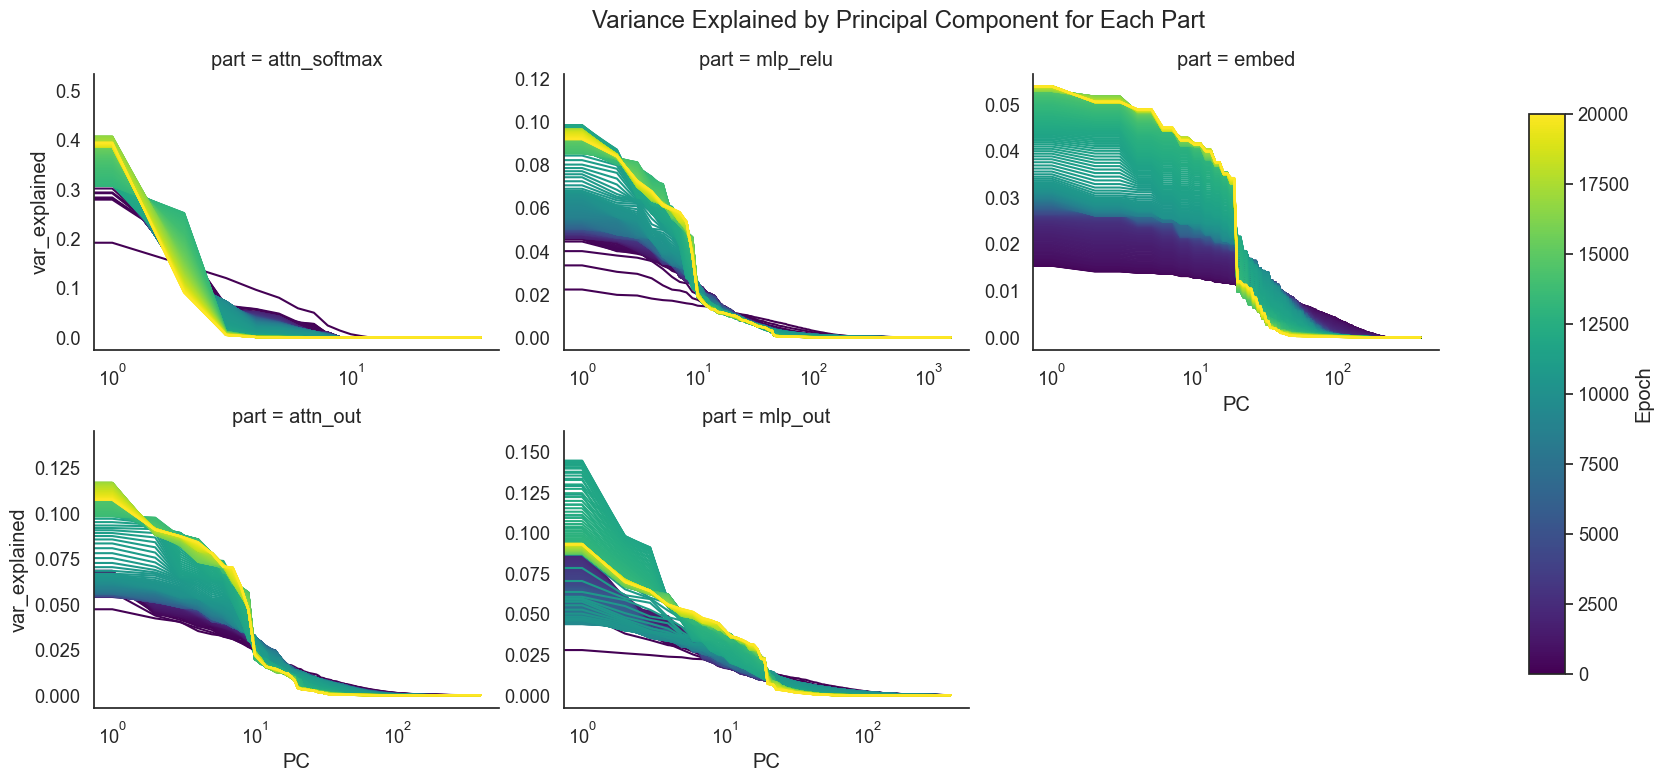

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

# Custom plotting function
def lineplot_with_colorbar(x, y, hue, data=None, color=None, **kwargs):
    ax = plt.gca()
    cmap = plt.cm.viridis
    norm = Normalize(vmin=data[hue].min(), vmax=data[hue].max())

    for epoch, epoch_df in data.groupby(hue):
        sns.lineplot(
            x=x, y=y, data=epoch_df, ax=ax, color=cmap(norm(epoch)), **kwargs
        )
    ax.set_xscale("log")

# Create FacetGrid
g = sns.FacetGrid(
    var_data_df,
    col="part",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=1.5,
    height=4,
)

# Map custom plotting function onto FacetGrid
g.map_dataframe(lineplot_with_colorbar, "PC", "var_explained", "epoch")

# Adjust layout and add suptitle
g.fig.subplots_adjust(top=0.9, right=0.8)
g.fig.suptitle("Variance Explained by Principal Component for Each Part")

# Add colorbar
cbar_ax = g.fig.add_axes([0.85, 0.15, 0.02, 0.7])
norm = Normalize(vmin=var_data_df["epoch"].min(), vmax=var_data_df["epoch"].max())
cbar = ColorbarBase(cbar_ax, cmap=plt.cm.viridis, norm=norm, orientation="vertical")
cbar.ax.set_ylabel("Epoch")

# Show the plot
plt.show()


Processing attn_softmax:   0%|          | 0/401 [00:00<?, ?it/s]

Processing mlp_relu:   0%|          | 0/401 [00:00<?, ?it/s]

Processing embed:   0%|          | 0/401 [00:00<?, ?it/s]

Processing attn_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing mlp_out:   0%|          | 0/401 [00:00<?, ?it/s]

C:\Users\adamimos\AppData\Local\Temp\ipykernel_24348\2360582433.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(y*100) for y in plt.gca().get_yticks()])


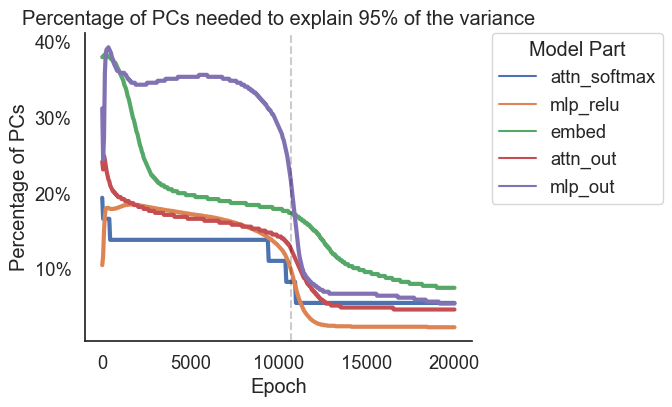

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# Set seaborn style and context
sns.set(style="white", context="notebook", font_scale=1.2)

# Create the pandas dataframe
num_rows = sum(len(exp_var_ratio[part]) for part in model_parts.keys())
var_data_df = pd.DataFrame(index=range(num_rows), columns=['part', 'epoch', 'var_explained', 'PC'])

current_row = 0

# Loop through the model parts
for part in model_parts.keys():
    # Get the data
    epoch_var_ratio = exp_var_ratio[part]
    # Get the epochs
    epochs = list(epoch_var_ratio.keys())
    # Get the number of neurons
    num_neurons = epoch_var_ratio[epochs[0]].shape[0]

    # Add the data to the df
    for epoch in tqdm(epochs, desc=f"Processing {part}"):
        # Get the var explained
        var_explained = epoch_var_ratio[epoch]
        # Get the number of PCs needed to explain 95% of the variance
        num_PCs = np.where(np.cumsum(var_explained) >= 0.95)[0][0]
        # Add the data to the df
        var_data_df.loc[current_row] = [part, epoch, var_explained, num_PCs/num_neurons]
        current_row += 1

# Create the plot
plt.figure(figsize=(5, 4))
sns.lineplot(x='epoch', y='PC', hue='part', data=var_data_df, lw=3)

# Set axis labels and plot title
plt.xlabel("Epoch")
plt.ylabel("Percentage of PCs")
plt.title("Percentage of PCs needed to explain 95% of the variance")

# Customize legend
legend = plt.legend(title="Model Part", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove grid
sns.despine()

# Multiply y-axis values by 100 to convert to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(y*100) for y in plt.gca().get_yticks()])

# add vertical line at grokking
plt.axvline(x=grok_acc_epoch, color='black', linestyle='--', alpha = 0.2)
##plt.axvline(x=mem_acc_epoch, color='black', linestyle='--')


plt.show()


as can be seen, all the model parts activities become more restricted to linear subspaces over training, aside from some very initial period that probably has to do with memorization. The dynamics are quite interesting. For instance the embedding layer seems to have two phases, and in general the dynamics seem a bit different for the different parts.

# compare across different phases of training

In [118]:
from sklearn.decomposition import PCA

trial_types = ['train', 'val']
model_parts = {'attn_softmax': ['softmax_4_47', 'softmax_1_17', 'softmax_2_27', 'softmax_3_37'],
              'mlp_relu': 'relu_1_53',
              'embed': 'add_1_9',
              'attn_out': 'cat_1_50',
              'mlp_out': 'linear_18_54'}
trial_type_inds = {'train': train_inds, 'val': val_inds, 'all': np.sort(np.union1d(train_inds, val_inds))}

# ... (keep the existing functions: get_activations and get_epoch_numbers)

# Initialize exp_var_ratio as a nested dictionary
exp_var_ratio = {tt: {} for tt in trial_types}

epochs = get_epoch_numbers()

# Loop through trial_types
for trial_type in trial_types:
    # Loop through the model parts
    for part in model_parts.keys():
        epoch_var_ratio = {}
        for epoch in tqdm(epochs, desc=f"Processing {trial_type} - {part}"):

            if part == 'attn_softmax':
                # Get the activations for the corresponding trial_type
                # loop through the softmax layers
                acts = []
                for softmax_layer in model_parts[part]:
                    acts.append(get_activations(softmax_layer, epoch)[trial_type_inds[trial_type], :, :])
                # concatenate the activations
                acts = np.concatenate(acts, axis=1)
            else:
                # Get the activations for the corresponding trial_type
                acts = get_activations(model_parts[part], epoch)[trial_type_inds[trial_type], :, :]
                # the last two dimensions of acts are neurons, so make it so that the last di


            # Continue with the existing code, using the `acts` variable
            # the last two dimensions of acts are neurons, so make it so that the last dimension is neurons
            # in other words if acts is (trials, n_a = 2, n_b =8) then we want to reshape it to (trials, n_a*n_b)
            acts = acts.reshape(acts.shape[0], -1) # trials x neurons

            # now we want to compute the pca
            pca = PCA(whiten=True)
            pca.fit(acts)

            # now we want to compute the explained variance per component
            # keep track of the exp_var_ratio in a dict
            exp_var = pca.explained_variance_ratio_ # neurons
            epoch_var_ratio[epoch] = exp_var
        
        exp_var_ratio[trial_type][part] = epoch_var_ratio


Found 401 epochs in H:/activations_addition


Processing train - attn_softmax:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - mlp_relu:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - embed:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - attn_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - mlp_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - attn_softmax:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - mlp_relu:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - embed:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - attn_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - mlp_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - attn_softmax:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - mlp_relu:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - embed:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - attn_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing train - mlp_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - attn_softmax:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - mlp_relu:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - embed:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - attn_out:   0%|          | 0/401 [00:00<?, ?it/s]

Processing val - mlp_out:   0%|          | 0/401 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='PC'>

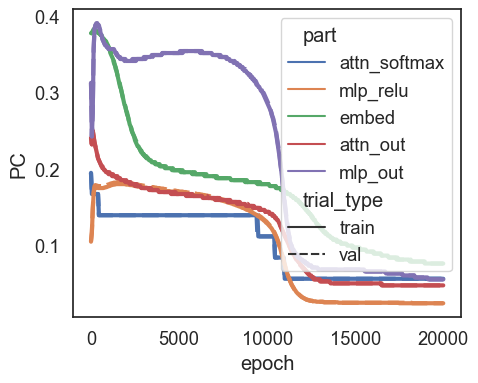

In [121]:
# now let's plot how many PCs we need to explain 95% of the variance
# we will do this for each part of the model
# and for each trial type
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# Set seaborn style and context
sns.set(style="white", context="notebook", font_scale=1.2)

# Create the pandas dataframe
num_rows = sum(len(exp_var_ratio[tt][part]) for tt in trial_types for part in model_parts.keys())
var_data_df = pd.DataFrame(index=range(num_rows), columns=['trial_type', 'part', 'epoch', 'var_explained', 'PC'])

current_row = 0

# Loop through the trial types
for trial_type in trial_types:
    # Loop through the model parts
    for part in model_parts.keys():
        # Get the data
        epoch_var_ratio = exp_var_ratio[trial_type][part]
        # Get the epochs
        epochs = list(epoch_var_ratio.keys())
        # Get the number of neurons
        num_neurons = epoch_var_ratio[epochs[0]].shape[0]

        # Add the data to the df
        for epoch in tqdm(epochs, desc=f"Processing {trial_type} - {part}"):
            # Get the var explained
            var_explained = epoch_var_ratio[epoch]
            # Get the number of PCs needed to explain 95% of the variance
            num_PCs = np.where(np.cumsum(var_explained) >= 0.95)[0][0]
            # Add the data to the df
            var_data_df.loc[current_row] = [trial_type, part, epoch, var_explained, num_PCs/num_neurons]
            current_row += 1

# Create the plot
plt.figure(figsize=(5, 4))
sns.lineplot(x='epoch', y='PC', hue='part', style='trial_type', data=var_data_df, lw=3)

there is absolutely no difference between train and validation

# EVERYTHING UNDERNEATH HERE IS MESSY AND NOT FINISHED, IGNORE

## Do PCA

Some things to note:
1. There seems to be very little difference between any of the columns of this plot, meaning that the geometry of the activations is similar for the training and validation data. So, we can't explain the difference in performance between the training and validation data by saying that the geometry of the activations is different, at least within these modules of the transformer.
2. Focussing on the first row, which gives the variance explained over the PCs for the embedding layer, we see that over training the activations are pushed to a smaller-dimensional linear manifold. 
3. This also occurs for the attention autput and mlp output, but the dynamics seem a bit different. Let's explore the dynamics in the next plot.

The first thing to note is the sharp dip in dimensionality early on in training for the ATtn_out and MLP_out layers. This suggests (but doesn't prove) that this restrictin of dimensionality is associated with  memorization of the training data. Interestingly, both the attention and mlp modules quickly organize their activations to spread across more dimensions, but the memorization of the training data does not change. This reminds me of neural work in the motor cortex showing that the cortex often puts computation that is important for preparing for motor commands (e.g. deciding which command to take) into a nullspace of the computation that is important for carrying out the motor command. Could this increase in dimensionality early on be the activity of the network moving around trying to find a generalization, but not wanting to sacrifice its accuracy on the training data?

If we don't consider the very early dips and rising in these plots, then the other thing I notice here is that the Attention Output and MLp OUtput modules become dimensionaly restricted earlier than the embedding layer, e.g. by 500 trials most of the restriction has occured, whereas for the embedding layer, most of the restriction happans after 500.



# Let's actually look at some activations!

It's always a good idea to simply look at your data. Let's take a step back and do some exploratory type stuff on the activations.

In [304]:
n_epochs = len(W_E.keys())
n_modules = len(model_part.keys())

# Get the number of trials and maximum number of neurons for preallocation
n_trials, _ = get_acts_for_epoch_and_module(W_E, next(iter(W_E.keys())), model_part[next(iter(model_part.keys()))]).shape
max_neurons = max(get_acts_for_epoch_and_module(W_E, next(iter(W_E.keys())), model_part[module]).shape[1] for module in model_part.keys())
print(f'Number of epochs: {n_epochs}')
print(f'Number of trials: {n_trials}')
print(f'Maximum number of neurons: {max_neurons}')

# Preallocate the DataFrame
columns = pd.MultiIndex.from_product([list(model_part.keys()), range(max_neurons), range(n_trials)], names=['module', 'neuron', 'trial'])
all_data = pd.DataFrame(index=pd.Index(range(n_epochs), name='epoch'), columns=columns)

# Sort the MultiIndex
all_data.sort_index(axis=1, inplace=True)

# Populate the DataFrame
for epoch in W_E.keys():
    for module in model_part.keys():
        print(f'Epoch {epoch}, module {module}')
        activations = get_acts_for_epoch_and_module(W_E, epoch, model_part[module])
        n_neurons = activations.shape[1]
        
        # Update the DataFrame in-place
        all_data.loc[epoch, (module, slice(0, n_neurons))] = activations.T.flatten()

# Reset the columns to a simpler format if desired
all_data.columns = all_data.columns.map('_'.join)


Number of epochs: 31
Number of trials: 12769
Maximum number of neurons: 384
Epoch 0, module embed
Epoch 0, module attn_out
Epoch 0, module mlp_out
Epoch 50, module embed
Epoch 50, module attn_out
Epoch 50, module mlp_out
Epoch 100, module embed
Epoch 100, module attn_out
Epoch 100, module mlp_out
Epoch 150, module embed
Epoch 150, module attn_out
Epoch 150, module mlp_out


KeyboardInterrupt: 

In [297]:
def get_acts_for_epoch_and_module(W_E, epoch, module):
    activations = W_E[epoch][module].tensor_contents # (batch_size, seq_len, hidden_size)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    return activations

model_part = {'embed': 'add_1_9', 'attn_out': 'cat_1_50', 'mlp_out': 'linear_18_54'}

# let's make a dataframe with the activations of all neurons for all epochs for all modules
# we want to initialize columns of the dataframe with the epoch, module, and neuron, and activation
all_data = []
for epoch in W_E.keys():
    for module in model_part.keys():
        activations = get_acts_for_epoch_and_module(W_E, epoch, model_part[module])
        # activations is a numpy array of shape (trials, n_neurons)
        
        trials, n_neurons = activations.shape
        
        # Create indices for epoch, module, neuron, and trial
        epoch_idx = [epoch] * trials * n_neurons
        module_idx = [module] * trials * n_neurons
        neuron_idx = (np.arange(n_neurons) % n_neurons).tolist() * trials
        trial_idx = np.repeat(np.arange(trials), n_neurons).tolist()
        
        # Flatten the activations
        flat_activations = activations.flatten().tolist()
        
        # Create a new dataframe with the current data
        current_data = pd.DataFrame({
            'epoch': epoch_idx,
            'module': module_idx,
            'neuron': neuron_idx,
            'trial': trial_idx,
            'activation': flat_activations
        })
        
        # Append the current data to the all_data dataframe
        all_data.append(current_data)

all_data = pd.concat(all_data, axis=0)


epochs = [50, 750, 1500]
module = model_part['attn_out']

full_df = pd.DataFrame()
for e in epochs:
    activations = get_acts_for_epoch_and_module(W_E, e, module)
    # choose some random neuron indices
    # put the data into a pandas df so that we can plot histograms of the activations
    df = pd.DataFrame(activations, columns=[f'neuron_{i}' for i in range(activations.shape[1])])
    df = df.melt(var_name='neuron', value_name='activation')
    df['epoch'] = e
    full_df = pd.concat([full_df, df], axis=0)

# choose random neurons, by querying a random set of values of the neuron column
# get all possible values of the neuron column
neuron_indices = full_df['neuron'].unique()
# choose some random neuron indices
neuron_indices = np.random.choice(neuron_indices, size=20, replace=False)
full_df = full_df.query('neuron in @neuron_indices')

# Set seaborn style and context
sns.set_style('white')
sns.set_context('talk')

# Create a FacetGrid for the histograms of the activations
g = sns.FacetGrid(full_df, col='neuron', col_wrap=5, sharex=False, sharey=False, hue='epoch')
# make these densities
g.map(sns.histplot, 'activation', kde=True, bins=10, alpha=0.8, stat='density')

# Improve aesthetics
g.set_axis_labels("Activation", "Density")
g.set_titles("Neuron {col_name}")
g.despine(left=False, bottom=False)

plt.show()


KeyboardInterrupt: 

In [ ]:
all_data

384


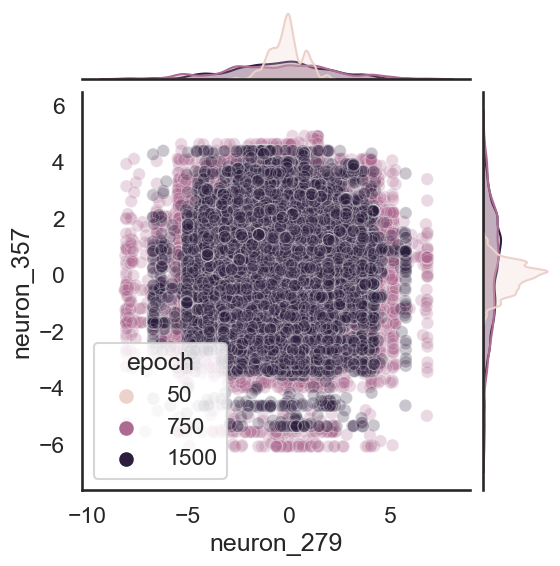

In [291]:
def get_acts_for_epoch_and_module(W_E, epoch, module):
    activations = W_E[epoch][module].tensor_contents # (batch_size, seq_len, hidden_size)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    return activations

model_part = {'embed': 'add_1_9', 'attn_out': 'cat_1_50', 'mlp_out': 'linear_18_54'}

epochs = [50, 750, 1500]
module = model_part['attn_out']

full_df = pd.DataFrame()
for e in epochs:
    activations = get_acts_for_epoch_and_module(W_E, e, module)
    # choose some random neuron indices
    # put the data into a pandas df so that we can plot histograms of the activations
    df = pd.DataFrame(activations, columns=[f'neuron_{i}' for i in range(activations.shape[1])])
    df = df.melt(var_name='neuron', value_name='activation')
    df['epoch'] = e
    full_df = pd.concat([full_df, df], axis=0)

# choose random neurons, by querying a random set of values of the neuron column
# get all possible values of the neuron column
neuron_indices = full_df['neuron'].unique()

# lets pick 2 neurons and then plot a 2d histogram of their activations
neuron_indices = full_df['neuron'].unique()

# choose some random neuron indices, but make sure that the standard deviation of the activations is not too small when 
# groupedby neuron, and epoch
# compute the standard deviation of the activations for each neuron and epoch
stds = full_df.groupby(['epoch', 'neuron']).std().reset_index()
# choose all neurons that have a standard deviation of the activations > 0 at least once
neuron_indices = stds.query('activation > 0')['neuron'].unique()
print(len(neuron_indices))
# choose 2 neurons
neuron_indices = np.random.choice(neuron_indices, size=2, replace=False)
full_df_ = full_df.query('neuron in @neuron_indices').reset_index()

# Create a new column to store the unique trial identifiers
full_df_['trial'] = full_df_.groupby(['epoch', 'neuron']).cumcount()

# Set seaborn style and context
sns.set_style('white')
sns.set_context('talk')

# get the 2 values of the neuron column
neuron_0, neuron_1 = full_df_['neuron'].unique()

# make the df have columns act_nrn0, act_nrn1, epoch, trial
full_df_ = full_df_.pivot_table(index=['epoch', 'trial'], columns='neuron', values='activation').reset_index()

# Plot the 2D histogram
sns.jointplot(data=full_df_, x=neuron_0, y=neuron_1, alpha=0.25, hue='epoch')


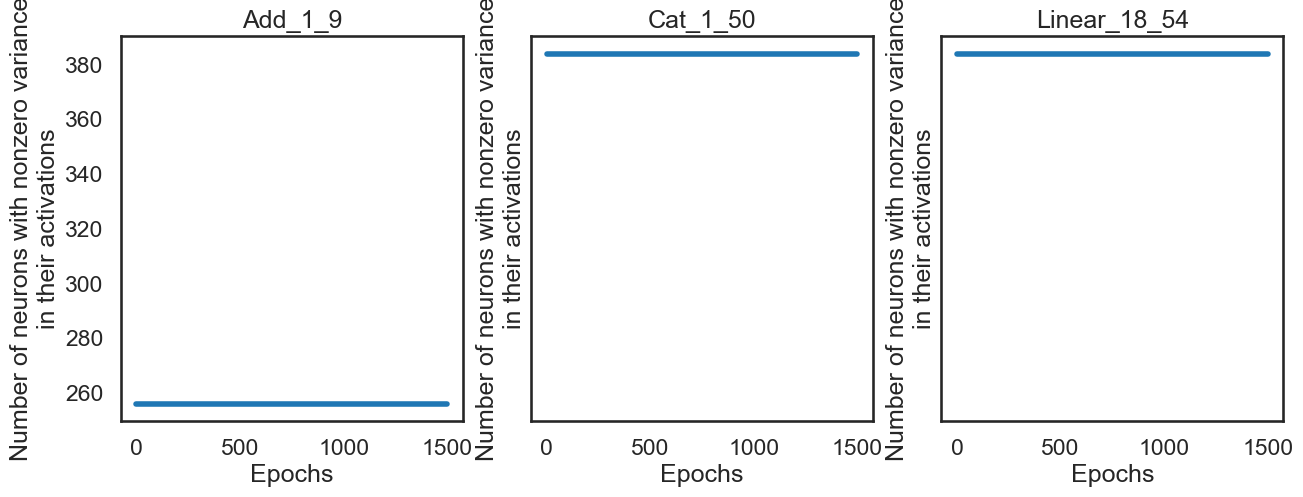

In [286]:
# for each model part, and each epoch, how many neurons have nonzero variance in their acivations?

def get_n_neurons_with_nonzero_var(W_E, model_parts, epochs):
    n_neurons = {}
    for mp in model_parts:
        n_neurons[mp] = {}
        for e in epochs:
            activations = W_E[e][mp].tensor_contents
            activations = activations.reshape(activations.shape[0], -1) # (trials, n_neurons)
            var = np.var(activations.numpy(), axis=0) # (n_neurons,)
            n_neurons[mp][e] = np.sum(var > 1e-3)
    return n_neurons
model_parts = list(model_part.values())
epochs = list(W_E.keys())

n_neurons = get_n_neurons_with_nonzero_var(W_E, model_parts, epochs)

# plot the number of neurons with nonzero variance in their activations
fig, axs = plt.subplots(1, len(model_parts), figsize=(15, 5), sharey=True)
for i, mp in enumerate(model_parts):
    ax = axs[i]
    ax.plot(epochs, list(n_neurons[mp].values()), lw=4)
    ax.set_title(mp.capitalize())
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Number of neurons with nonzero variance\nin their activations')



In [179]:
def get_acts_for_epoch_and_module(W_E, epoch, module):
    activations = W_E[epoch][module].tensor_contents # (batch_size, seq_len, hidden_size)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    return activations

epochs = [0, 750, 1500]
module = 'add_1_9'

full_df = pd.DataFrame()
for e in epochs:
    activations = get_acts_for_epoch_and_module(W_E, e, module)
    # choose some random neuron indices
    # put the data into a pandas df so that we can plot histograms of the activations
    df = pd.DataFrame(activations, columns=[f'neuron_{i}' for i in range(activations.shape[1])])
    df = df.melt(var_name='neuron', value_name='activation')
    df['epoch'] = e
    full_df = pd.concat([full_df, df], axis=0)

# choose random neurons, by querying a random set of values of the neuron column
# get all possible values of the neuron column
neuron_indices = full_df['neuron'].unique()

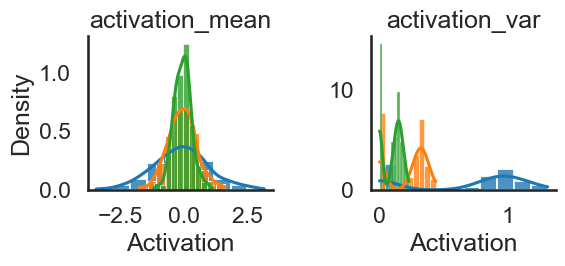

In [187]:
# use groupby to get the mean activation for each neuron at each epoch, and variance
mean_df = full_df.groupby(['epoch', 'neuron']).mean().reset_index()
var_df = full_df.groupby(['epoch', 'neuron']).var().reset_index()
# make a df with the mean and variance for each neuron at each epoch    
mean_var_df = mean_df.merge(var_df, on=['epoch', 'neuron'], suffixes=('_mean', '_var'))

# plot histograms of the means and variances
# change the mean_var_df so that it has a column called type and its value can be either 'mean' or 'var'
mean_var_df = mean_var_df.melt(id_vars=['epoch', 'neuron'], value_vars=['activation_mean', 'activation_var'], var_name='type', value_name='activation')
# now use seaborn to plot the histograms for the mean and variance, one in each column, with hue=epoch
g = sns.FacetGrid(mean_var_df, col='type', col_wrap=2, sharex=False, sharey=False, hue='epoch')
g.map(sns.histplot, 'activation', kde=True, bins=10, alpha=0.8, stat='density')

# Improve aesthetics
g.set_axis_labels("Activation", "Density")
g.set_titles("{col_name}")
g.despine(left=False, bottom=False)

plt.show()



384

In [188]:
mean_var_df

epoch      neuron             type  activation
0         0    neuron_0  activation_mean   -0.796780
1         0    neuron_1  activation_mean    1.313237
2         0   neuron_10  activation_mean   -1.365905
3         0  neuron_100  activation_mean   -1.672850
4         0  neuron_101  activation_mean   -1.429156
...     ...         ...              ...         ...
2299   1500   neuron_95   activation_var    0.156804
2300   1500   neuron_96   activation_var    0.158079
2301   1500   neuron_97   activation_var    0.172179
2302   1500   neuron_98   activation_var    0.228685
2303   1500   neuron_99   activation_var    0.159980

[2304 rows x 4 columns]

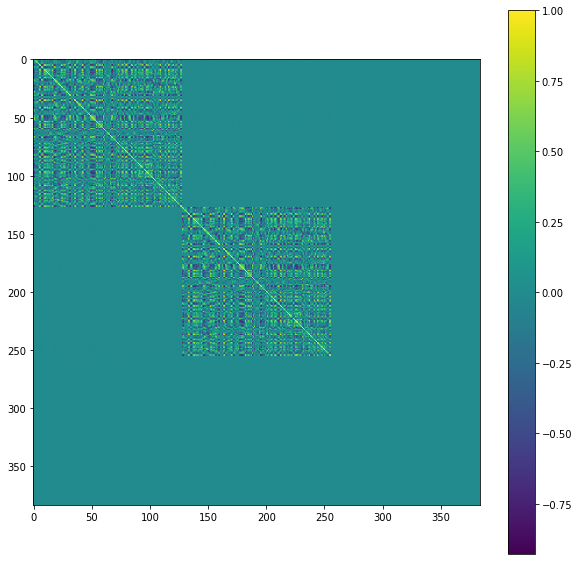

In [ ]:
import numpy as np
# now calculate the covariance matrix
cov_mat = np.cov(embedding_acts.T)
# replace 0 with Nan
# plot the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(cov_mat)
plt.colorbar()


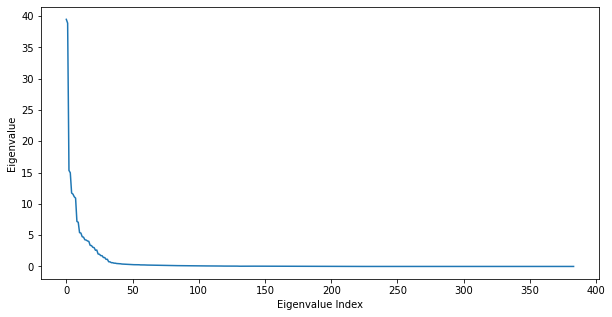

In [ ]:
# plot the eigenspectrum of the covariance matrix
plt.figure(figsize=(10, 5))
plt.plot(np.linalg.eigvals(cov_mat))
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.show()

Text(0, 0.5, 'Variance Explained')

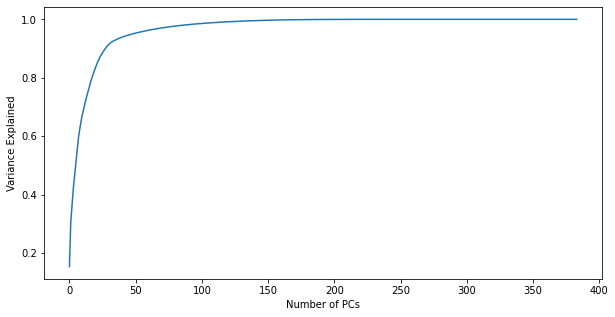

In [ ]:
# plot variance explained by PC
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(np.linalg.eigvals(cov_mat))/np.sum(np.linalg.eigvals(cov_mat)))
plt.xlabel("Number of PCs")
plt.ylabel("Variance Explained")